In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Dataset loading and first analysis

In [84]:
df = pd.read_csv('pizza_v2.csv')
df.head()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms
0,A,"Rp235,000",22 inch,chicken,double_signature,jumbo,yes,yes,no
1,A,"Rp198,000",20 inch,papperoni,double_signature,jumbo,yes,yes,no
2,A,"Rp120,000",16 inch,mushrooms,double_signature,reguler,yes,yes,yes
3,A,"Rp155,000",14 inch,smoked_beef,double_signature,reguler,yes,no,yes
4,A,"Rp248,000",18 inch,mozzarella,double_signature,jumbo,yes,no,yes


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company          129 non-null    object
 1   price_rupiah     129 non-null    object
 2   diameter         129 non-null    object
 3   topping          129 non-null    object
 4   variant          129 non-null    object
 5   size             129 non-null    object
 6   extra_sauce      129 non-null    object
 7   extra_cheese     129 non-null    object
 8   extra_mushrooms  129 non-null    object
dtypes: object(9)
memory usage: 9.2+ KB


We can already see that some numerical features such as price and diameter are saved as strings. They will be changed to int values.<br>

In [86]:
df['price_rupiah'] = df['price_rupiah'].replace(',','')

In [87]:
df.head()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms
0,A,"Rp235,000",22 inch,chicken,double_signature,jumbo,yes,yes,no
1,A,"Rp198,000",20 inch,papperoni,double_signature,jumbo,yes,yes,no
2,A,"Rp120,000",16 inch,mushrooms,double_signature,reguler,yes,yes,yes
3,A,"Rp155,000",14 inch,smoked_beef,double_signature,reguler,yes,no,yes
4,A,"Rp248,000",18 inch,mozzarella,double_signature,jumbo,yes,no,yes


In [88]:
#create a new column that will include the price 
df['price'] = df['price_rupiah'].replace(',', '').apply(lambda x: x[2:])

In [89]:
df = df.drop('price_rupiah', axis=1)

In [90]:
df['price'] = df['price'].apply(lambda x: x.replace(',',''))

In [91]:
df['price'] = df['price'].astype('int64')

In [92]:
#remove 'inch' from the diameter column
df['diameter'] = df['diameter'].apply(lambda x: x.replace('inch',''))

In [93]:
df['diameter'] = df['diameter'].astype('float')

In [94]:
df.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
0,A,22.0,chicken,double_signature,jumbo,yes,yes,no,235000
1,A,20.0,papperoni,double_signature,jumbo,yes,yes,no,198000
2,A,16.0,mushrooms,double_signature,reguler,yes,yes,yes,120000
3,A,14.0,smoked_beef,double_signature,reguler,yes,no,yes,155000
4,A,18.0,mozzarella,double_signature,jumbo,yes,no,yes,248000


Now it is possible to extract useful information of these numerical features:

In [95]:
df.describe()

,diameter,price
count,129.000000,129.000000
mean,12.976744,87151.162791
std,3.272674,44706.097732
min,8.000000,23500.000000
25%,12.000000,51000.000000
50%,12.000000,78000.000000
75%,14.000000,105000.000000
max,22.000000,248000.000000


Diameter:<br>
The mean diameter is around 13 inches<br>
The minimum diameter is 8 inches<br>
The maximum diameter is 22 inches<br>

Price:<br>
The mean price is 87,151 rupiah (around 5.20 euros)<br>
The cheapest pizza in the dataset is 23,500 rupiah (1.40 euro)<br>
The most expensive one is 248,000 rupiah (14.77 euro)<br>

# Exploratory Data Analysis

### Numerical features analysis

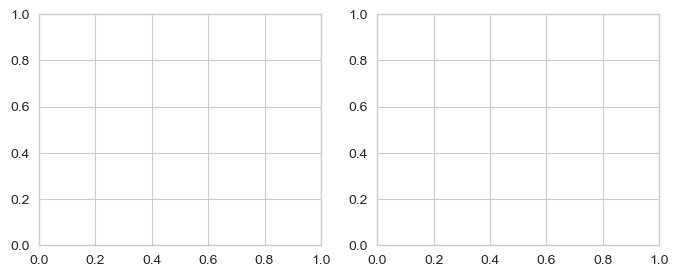

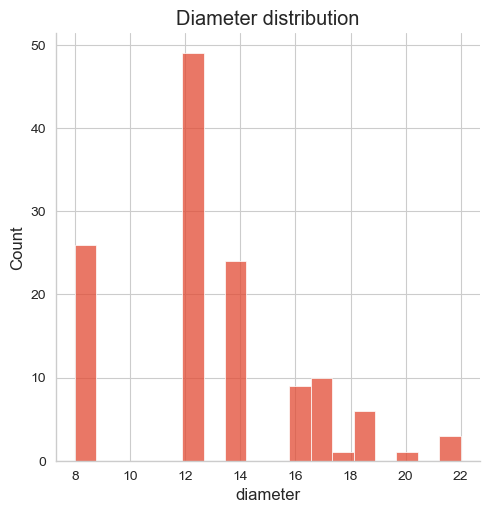

In [96]:
sns.displot(x='diameter', data=df, kde=False)
plt.title('Diameter distribution')
plt.show()

The diameter distribution is skewed right

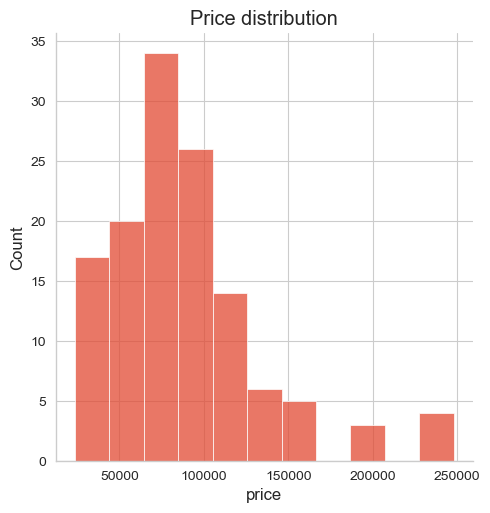

In [97]:
sns.displot(x='price', data=df)
plt.title('Price distribution')
plt.show()

The price distribition is right skewed as well.

### Topping analysis

In [98]:
df['topping']

0          chicken
1        papperoni
2        mushrooms
3      smoked_beef
4       mozzarella
          ...     
124           tuna
125           tuna
126           tuna
127           meat
128           meat
Name: topping, Length: 129, dtype: object

There seems to be two mispelling error: 'papperoni' instead of 'pepperoni' and 'black_papper' instead of 'black_pepper'. They will be corrected.

In [99]:
df['topping'] = df['topping'].replace('papperoni','pepperoni')
df['topping'] = df['topping'].replace('black_papper','black_pepper')

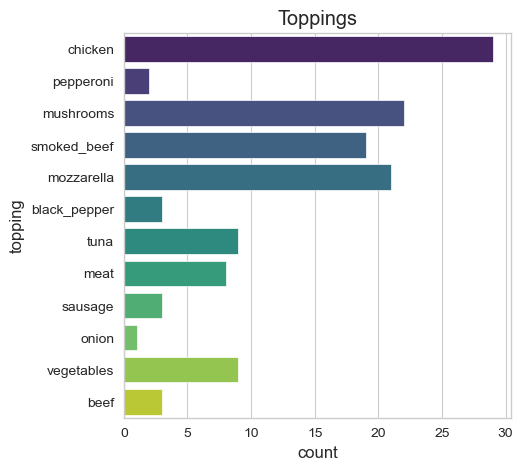

In [100]:
plt.figure(figsize=(5,5))
ax=sns.countplot(y='topping', data=df, palette='viridis');
plt.title('Toppings')
plt.show()

The most popular toppings among the pizzas are chicken, mushrooms, smoked_beef and mozzarella

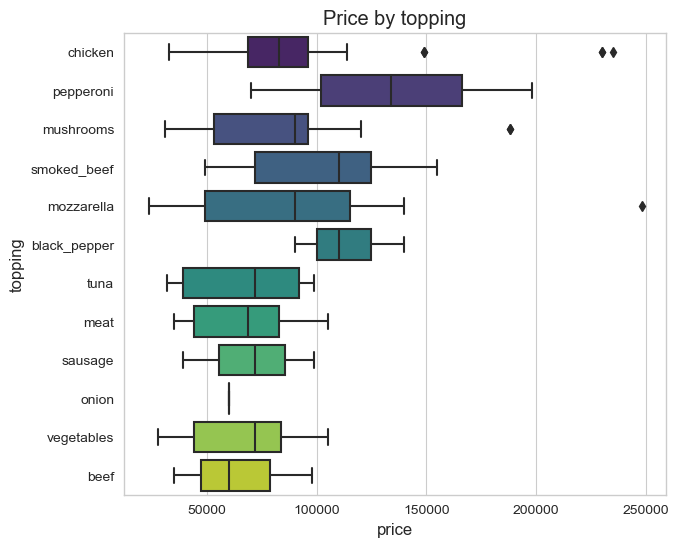

In [101]:
plt.figure(figsize=(7,6))
sns.boxplot(y='topping', x='price', data=df, palette='viridis')
plt.title('Price by topping')
plt.show()

From this plot we can say:
- Pepperoni pizza on average are more expensive than other pizzas.
- There are some outliers for mozzarella, mushrooms and chicken pizzas.
- It looks like there is just one onion pizza 


The only pizza with onions is:

In [102]:
df[df['topping']=='onion']

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
59,C,12.0,onion,extravaganza,medium,yes,yes,no,60000


While the most expensive pizza is:

In [103]:
df[df['price'] > 240000]

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
4,A,18.0,mozzarella,double_signature,jumbo,yes,no,yes,248000


### Size analysis

In [104]:
df['size']

0        jumbo
1        jumbo
2      reguler
3      reguler
4        jumbo
        ...   
124      small
125     medium
126      large
127      small
128     medium
Name: size, Length: 129, dtype: object

There seems to be a mispelled word: 'reguler' instead of 'regular'. It will be corrected.

In [105]:
df['size'] = df['size'].replace('reguler','regular')

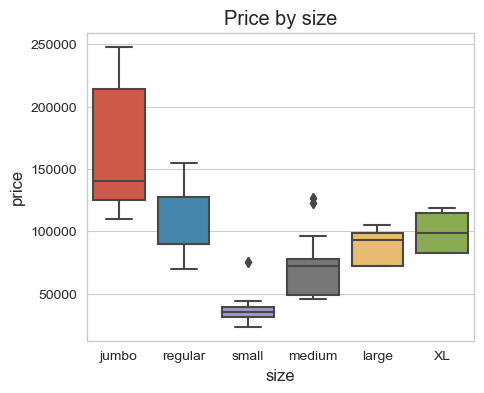

In [106]:
plt.figure(figsize=(5,4))
sns.boxplot(x='size', y='price', data=df)
plt.title('Price by size')
plt.show()

**From this plot jumbo and regular pizzas seems to be more expensive. This sounds a bit weird for regular pizzas, since they should be cheaper than larger pizzas like Xl and large. This will be further analyzed later.**

### Variant analysis

The different pizza variants are:

In [107]:
df.variant.value_counts()

classic              30
meat_lovers          10
double_mix           10
crunchy              10
new_york             10
double_decker         9
double_signature      5
american_favorite     5
BBQ_meat_fiesta       5
super_supreme         5
spicy_tuna            3
BBQ_sausage           3
extravaganza          3
meat_eater            3
gournet_greek         3
italian_veggie        3
thai_veggie           3
american_classic      3
neptune_tuna          3
spicy tuna            3
Name: variant, dtype: int64

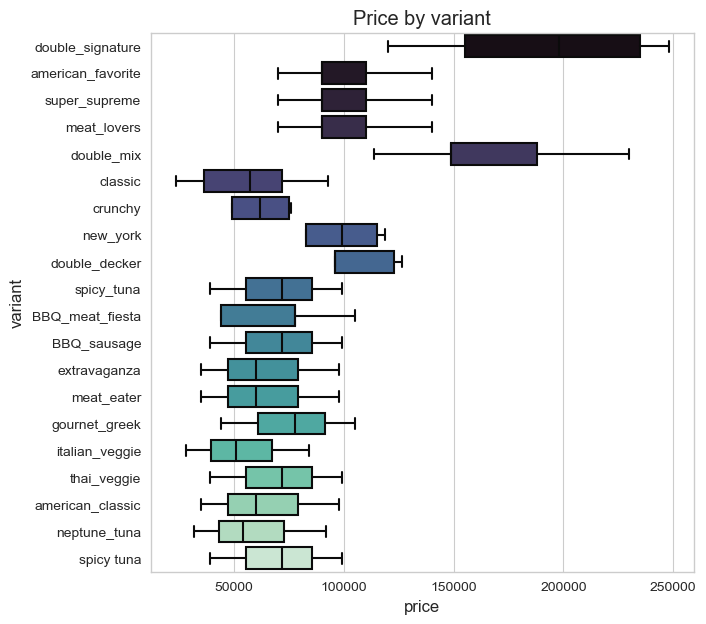

In [108]:
plt.figure(figsize=(7,7))
sns.boxplot(y='variant', x='price', data=df, palette='mako')
plt.title('Price by variant')
plt.show()

From this plot we can say that:<br>
Double signature and double mix pizzas are more expensive than the other pizzas.<br>
In particular, double signature pizza date has a large variance.<br>
Classic and italian veggies are cheaper on average.<br>

It could be interesting to check if there is a correlation between the variance, toppings and size (categorical variables))

### Extra-toppings analysis

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          129 non-null    object 
 1   diameter         129 non-null    float64
 2   topping          129 non-null    object 
 3   variant          129 non-null    object 
 4   size             129 non-null    object 
 5   extra_sauce      129 non-null    object 
 6   extra_cheese     129 non-null    object 
 7   extra_mushrooms  129 non-null    object 
 8   price            129 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 9.2+ KB


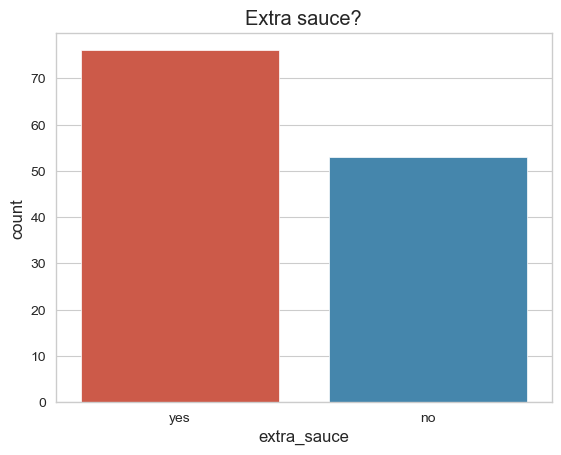

In [110]:
sns.countplot(x='extra_sauce', data=df)
plt.title('Extra sauce?')
plt.show()

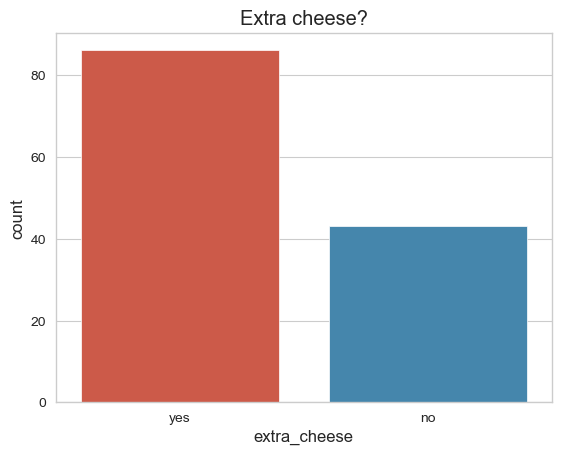

In [111]:
sns.countplot(x='extra_cheese', data=df)
plt.title('Extra cheese?')
plt.show()

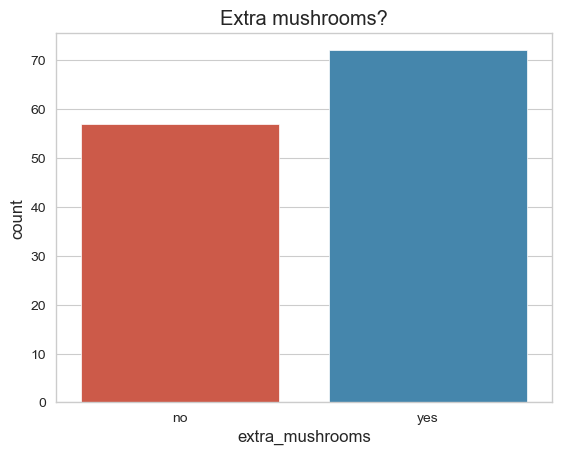

In [112]:
sns.countplot(x='extra_mushrooms', data=df)
plt.title('Extra mushrooms?')
plt.show()

**From these plots we can see that on average, most pizzas have extra toppings (mushrooms, cheese and sauce)<br>
In particular, the most added toppings is extra cheese**

### Is there a correlation between the extra toppings?

To check the correlation between the extra toppings, yes and no will be first substitued by 1 and 0

In [113]:
df.replace(('yes', 'no'), (1, 0), inplace=True)

In [114]:
sns.heatmap(df.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);
plt.title('Correlation Matrix');

It looks like that diameter is highly correlated with price, while other features does not seem to be correlated.

Moreover, the size feature could be converted into a numerical feature and analyzed.

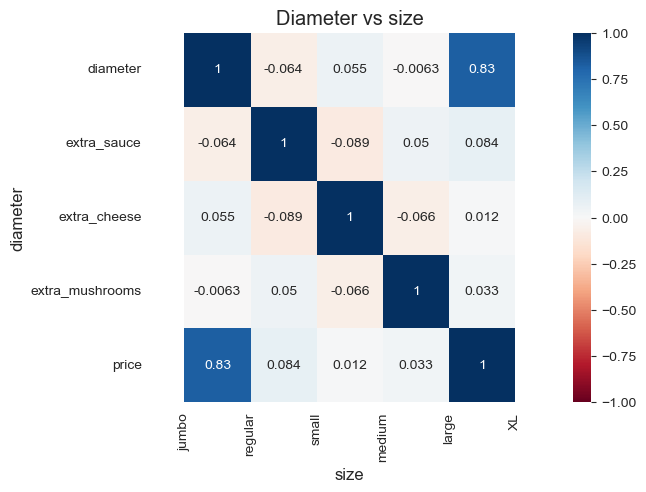

In [115]:
sns.stripplot(x='size', y='diameter', data=df)
plt.title('Diameter vs size')
plt.show()

Insights:
- Small pizza have a diameter of 8 inches 
- Medium pizza have a diameter of 12 inches 
- Large pizza have a diameter of 14 inches 
- XL pizza have a diameter of 17 inches 

Interestingly, for 'regular' and 'jumbo' pizzas, the diameter is not fixed.<br>
This will be further analyzed.

So, what makes a pizza jumbo or regular?

### Jumbo sized pizza analysis

In [116]:
df_jumbo = df[df['size'] == 'jumbo']
df_jumbo.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
0,A,22.0,chicken,double_signature,jumbo,1,1,0,235000
1,A,20.0,pepperoni,double_signature,jumbo,1,1,0,198000
4,A,18.0,mozzarella,double_signature,jumbo,1,0,1,248000
5,A,18.5,black_pepper,american_favorite,jumbo,0,0,1,140000
6,A,16.0,smoked_beef,american_favorite,jumbo,0,1,1,110000


It looks like all these pizzas are from the company A, is that so?

In [117]:
df_jumbo.company.value_counts()

A    11
D     4
Name: company, dtype: int64

It looks like there are only 15 jumbo pizzas in the dataset. In particular among these 15, 11 are from the company A while the other 4 are from company D

In [118]:
df.company.value_counts()

C    30
E    30
A    25
B    24
D    20
Name: company, dtype: int64

For what concerns the original dataset, it seems to be banalced among different companies (from A to E)

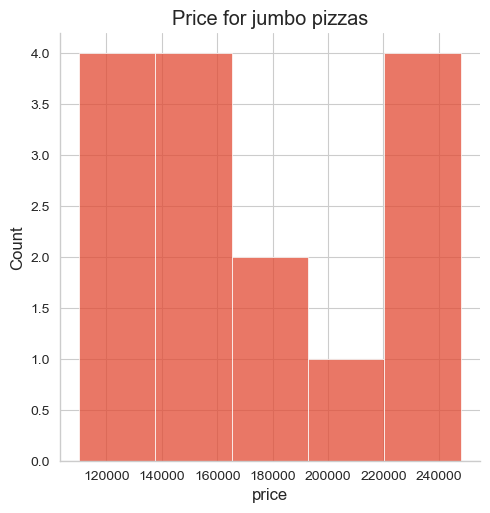

In [119]:
sns.displot(x='price', data=df_jumbo)
plt.title('Price for jumbo pizzas')
plt.show()

The minimum price is 125000 rupiah, which is higher than the average price of all pizzas ( around 87000 rupiah)

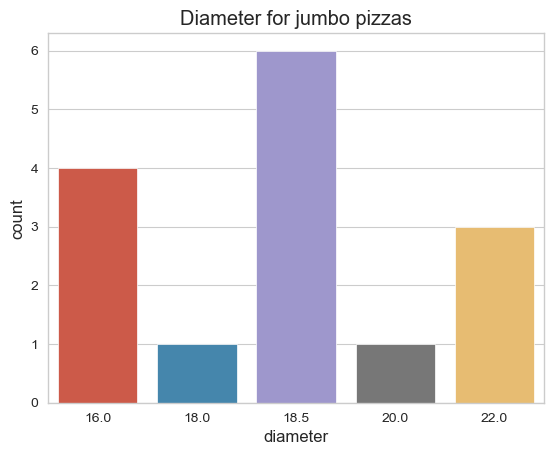

In [120]:
sns.countplot(x='diameter', data=df_jumbo)
plt.title('Diameter for jumbo pizzas')
plt.show()

Among jumbo pizzas, the diamater seems higher than 17 inches (XL size pizzas diameter).<br>
What about those jumbo pizzas with a 16 inches diameter?

In [121]:
df_jumbo[df_jumbo['diameter']==16]

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
6,A,16.0,smoked_beef,american_favorite,jumbo,0,1,1,110000
11,A,16.0,black_pepper,super_supreme,jumbo,1,1,0,110000
16,A,16.0,smoked_beef,meat_lovers,jumbo,0,1,1,110000
80,D,16.0,smoked_beef,meat_lovers,jumbo,0,1,0,110000


These 4 pizzas have a small diameter despite being a jumbo pizza. They will be considered as outliers and dropped.

In [122]:
df = df.loc[~((df['size'] == 'jumbo') & (df['diameter'] == 16)),:]

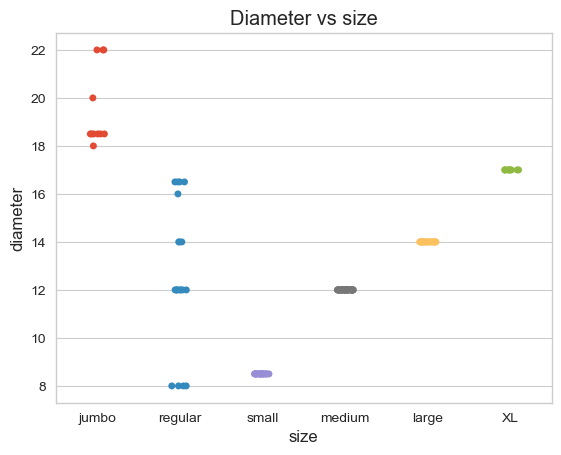

In [123]:
sns.stripplot(x='size', y='diameter', data=df)
plt.title('Diameter vs size')
plt.show()

## Regular pizza analysis

In [124]:
df_regular = df[df['size'] == 'regular']
df_regular.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
2,A,16.0,mushrooms,double_signature,regular,1,1,1,120000
3,A,14.0,smoked_beef,double_signature,regular,1,0,1,155000
7,A,8.0,pepperoni,american_favorite,regular,0,0,1,70000
8,A,12.0,mushrooms,american_favorite,regular,1,0,1,90000
9,A,12.0,smoked_beef,american_favorite,regular,0,0,0,90000


In [125]:
df_regular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 2 to 88
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          20 non-null     object 
 1   diameter         20 non-null     float64
 2   topping          20 non-null     object 
 3   variant          20 non-null     object 
 4   size             20 non-null     object 
 5   extra_sauce      20 non-null     int64  
 6   extra_cheese     20 non-null     int64  
 7   extra_mushrooms  20 non-null     int64  
 8   price            20 non-null     int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.6+ KB


In [126]:
df_regular.company.value_counts()

A    14
D     6
Name: company, dtype: int64

Like Jumbo pizzas, regular pizzas are only sold by company A and D

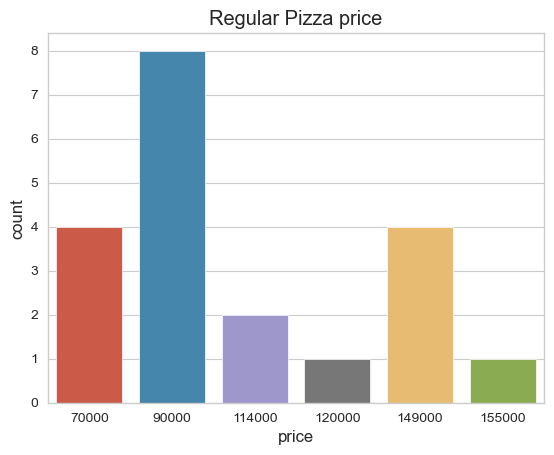

In [127]:
sns.countplot(x='price', data=df_regular)
plt.title('Regular Pizza price')
plt.show()

Most regular pizza sems to have a price around 90000 rupiah, which is close to the overall average (87000)

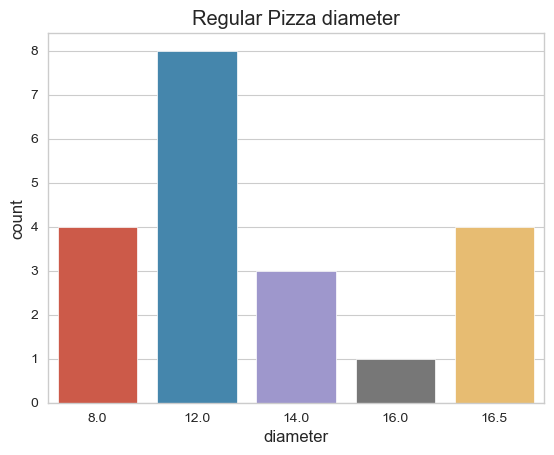

In [128]:
sns.countplot(x='diameter', data=df_regular)
plt.title('Regular Pizza diameter')
plt.show()

**Most of regular pizza have a 12 inches diameter**

What about the variants?

In [129]:
df_regular.variant.value_counts()

meat_lovers          6
double_mix           6
american_favorite    3
super_supreme        3
double_signature     2
Name: variant, dtype: int64

The most popular variants are meat_lovers and double_mix.

It is still not clear what makes a regular pizza a regular pizza. The size should be related only to the diameter. For this reason, pizza with a regular size will be dropped from the dataframe.

In [130]:
df = df.loc[~(df['size'] == 'regular'),:]

In [131]:
df.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
0,A,22.0,chicken,double_signature,jumbo,1,1,0,235000
1,A,20.0,pepperoni,double_signature,jumbo,1,1,0,198000
4,A,18.0,mozzarella,double_signature,jumbo,1,0,1,248000
5,A,18.5,black_pepper,american_favorite,jumbo,0,0,1,140000
10,A,18.5,mozzarella,super_supreme,jumbo,0,0,0,140000


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          105 non-null    object 
 1   diameter         105 non-null    float64
 2   topping          105 non-null    object 
 3   variant          105 non-null    object 
 4   size             105 non-null    object 
 5   extra_sauce      105 non-null    int64  
 6   extra_cheese     105 non-null    int64  
 7   extra_mushrooms  105 non-null    int64  
 8   price            105 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 8.2+ KB


We dropped 20 regular pizzas and 4 jumbo pizzas (outliers)

# Pizza price prediction

Now it is possible to perform a regression on the price features of the pizzas.

# Encoding

First, we need to encode the categorical variables.

Topping and variant would be better to be encoded by One hot encoding since there is no order/hierarchy among them. However, this would mean to have 40 columns in total, which are too many compared to the number of rows, which are just 105. For this reason, we will encode these columns by LabelEncoder.

Finally, 'size' will be encoded by label encoder since there actually exists an hierachy/order among sizes.

A new dataframe with the encoded features will be created.

In [133]:
encoded_df = df.copy()

In [134]:
encoded_df['size'].value_counts()

medium    41
small     22
large     21
jumbo     11
XL        10
Name: size, dtype: int64

In [135]:
encoded_df['size'] = encoded_df['size'].map({'small':'0','medium':'1','large':'2','XL':'3','jumbo':'4'})

In [136]:
categorical_cols = ['topping', 'variant','company']
encoder = LabelEncoder()
for col in categorical_cols:
    encoded_df[col] = encoder.fit_transform(encoded_df[col])

In [137]:
encoded_df.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,extra_mushrooms,price
0,0,22.0,2,8,4,1,1,0,235000
1,0,20.0,7,8,4,1,1,0,198000
4,0,18.0,4,8,4,1,0,1,248000
5,0,18.5,1,3,4,0,0,1,140000
10,0,18.5,4,18,4,0,0,0,140000


## Data preparation

In [138]:
X=encoded_df.drop('price', axis = 1).values

In [139]:
y=encoded_df['price'].values

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Lasso model

In [141]:
lm_lasso=Lasso(alpha = 1, max_iter = 1000, tol = 1e-3)
lm_lasso.fit(X_train,y_train)
y_pred_lm_lasso = lm_lasso.predict(X_test)
mse_lm_lasso = mean_squared_error(y_test, y_pred_lm_lasso)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))

RMSE using LASSO:  25061.998525775474


# Random Forest model

In [142]:
rf = RandomForestRegressor()

In [143]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [144]:
y_pred_rf = rf.predict(X_test)

In [145]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("RMSE using RF: ", np.sqrt(mse_rf))

RMSE using RF:  14340.368008863288


In [146]:
print("RF R2 score :", r2_score(y_test,y_pred_rf))

RF R2 score : 0.9009081914342681


# XGBoost

In [147]:
xgb = XGBRegressor() 

In [148]:
xgb.fit(X_train, y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [149]:
y_pred_xgb = xgb.predict(X_test) 

In [150]:
mse_xgb = mean_squared_error(y_pred_xgb, y_test)
print("RMSE:" , np.sqrt(mse_xgb))

RMSE: 12334.456291462075


In [151]:
print("XGBoost R2 score :", r2_score(y_test,y_pred_xgb))

XGBoost R2 score : 0.9266910190376925


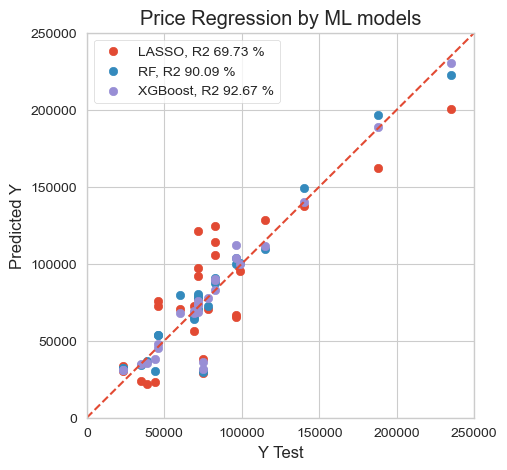

In [152]:
plt.figure(figsize = (5,5))
plt.scatter(y_test, y_pred_lm_lasso, label='LASSO, R2 {:.2f} %'.format(r2_score(y_test, y_pred_lm_lasso)*100))
plt.scatter(y_test, y_pred_rf, label='RF, R2 {:.2f} %'.format(r2_score(y_test, y_pred_rf)*100))
plt.scatter(y_test, y_pred_xgb, label='XGBoost, R2 {:.2f} %'.format(r2_score(y_test, y_pred_xgb)*100))
plt.plot([0, 250000], [0, 250000], linestyle='--')
plt.axis([0, 250000, 0, 250000])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Price Regression by ML models')
plt.legend(loc='upper left');
plt.show()

In [153]:
print("RMSE using LASSO: {:.2f} rupiah".format(np.sqrt(mse_lm_lasso)))
print("RMSE using RF: {:.2f} rupiah".format(np.sqrt(mse_rf)))
print("RMSE using XGBoost: {:.2f} rupiah".format(np.sqrt(mse_xgb)))

RMSE using LASSO: 25062.00 rupiah
RMSE using RF: 14340.37 rupiah
RMSE using XGBoost: 12334.46 rupiah


In [154]:
print("R2 using LASSO: {:.2f} %".format(r2_score(y_test, y_pred_lm_lasso)*100))
print("R2 using Random Forest: {:.2f} %".format(r2_score(y_test, y_pred_rf)*100))
print("R2 using XGBoost: {:.2f} %".format(r2_score(y_test, y_pred_xgb)*100))

R2 using LASSO: 69.73 %
R2 using Random Forest: 90.09 %
R2 using XGBoost: 92.67 %


We get the best result in terms of RMSE and R2 by using XGBoost regressor.